# 1-(a)

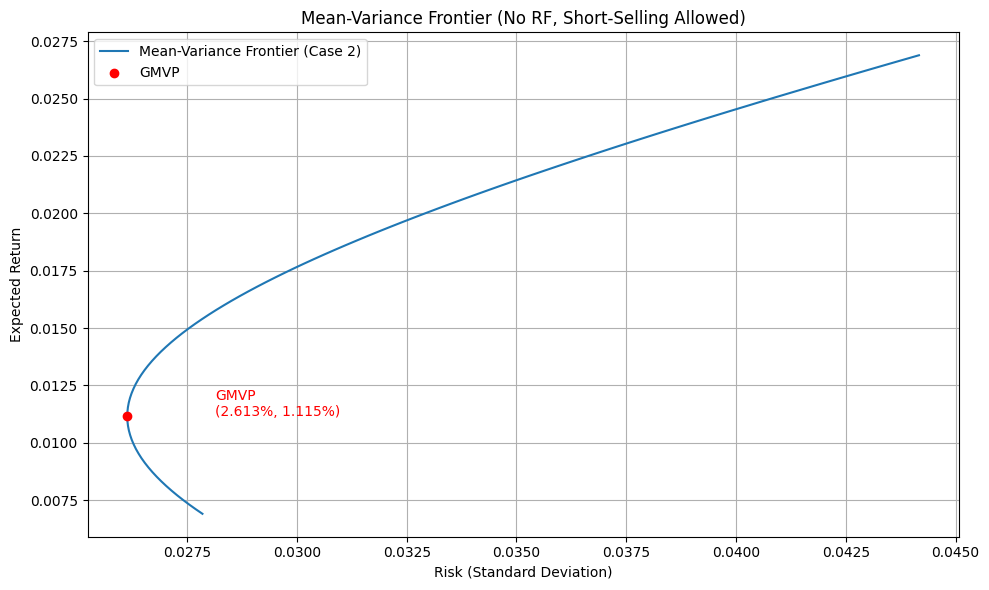

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ---------------------------
# 데이터 불러오기 및 정제
# ---------------------------
msf = pd.read_csv("msf.csv")
msp500 = pd.read_csv("msp500_risk_free.csv")
msf['mdate'] = pd.to_datetime(msf['mdate'])
msp500['mdate'] = pd.to_datetime(msp500['mdate'])

# 공통 날짜 기준 정렬
pivot_ret = msf.pivot(index='mdate', columns='permno', values='ret').dropna(axis=1)
common_dates = pivot_ret.index.intersection(msp500['mdate'])
pivot_ret = pivot_ret.loc[common_dates]
msp500 = msp500.set_index('mdate').loc[common_dates]

# 수익률 관련 변수
mu = pivot_ret.mean().values           # 평균 수익률 벡터
Sigma = pivot_ret.cov().values         # 공분산 행렬
n = len(mu)
ones = np.ones(n)
mu_p = msp500['spret'].mean()          # S&P500 기대 수익률

# ---------------------------
# 2. Case 2 - Mean-Variance Frontier (공매도 허용, 무위험 자산 없음)
# ---------------------------
def minimize_vol(target_return, mu, Sigma):
    init_w = np.ones(n) / n
    bounds = [(-1, 1)] * n
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: w @ mu - target_return}
    ]
    result = minimize(lambda w: np.sqrt(w.T @ Sigma @ w), init_w,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

target_returns = np.linspace(mu.min(), mu.max(), 100)
frontier_vols = [np.sqrt(minimize_vol(r, mu, Sigma).T @ Sigma @ minimize_vol(r, mu, Sigma)) for r in target_returns]

# GMVP 계산
inv_Sigma = np.linalg.inv(Sigma)
w_gmv = inv_Sigma @ ones / (ones.T @ inv_Sigma @ ones)
ret_gmv = mu @ w_gmv
vol_gmv = np.sqrt(w_gmv.T @ Sigma @ w_gmv)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(frontier_vols, target_returns, label='Mean-Variance Frontier (Case 2)')
plt.scatter(vol_gmv, ret_gmv, color='red', label='GMVP', zorder=5)
# GMVP 좌표
plt.text(vol_gmv + 0.002, ret_gmv,
         f'GMVP\n({vol_gmv:.3%}, {ret_gmv:.3%})',
         color='red', fontsize=10)
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Mean-Variance Frontier (No RF, Short-Selling Allowed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 1-(b)

In [32]:
A = ones.T @ inv_Sigma @ ones
B = ones.T @ inv_Sigma @ mu
C = mu.T @ inv_Sigma @ mu
Delta = A * C - B**2

gamma = (mu_p * A - B) / Delta
lambda_ = (C - mu_p * B) / Delta
w_opt1 = inv_Sigma @ (lambda_ * ones + gamma * mu)

# ---------------------------
# 주요 종목별 가중치 출력
# ---------------------------
permno_to_name = msf[['permno', 'comnam']].drop_duplicates().set_index('permno')['comnam'].to_dict()
target_permnos = [22592, 59408, 61241, 14593, 43449]

for permno in target_permnos:
    if permno in pivot_ret.columns:
        idx = list(pivot_ret.columns).index(permno)
        print(f"{permno_to_name.get(permno, 'Unknown')} ({permno}): {w_opt1[idx]:.14%}")

3M CO (22592): 11.32716274243258%
BANK OF AMERICA CORP (59408): -3.32608473390937%
ADVANCED MICRO DEVICES INC (61241): -1.93772320088895%
APPLE INC (14593): 0.38201697543950%
MCDONALDS CORP (43449): 2.28036616325810%


# 1-(c)

In [31]:
# ---------------------------
# 연환산 수익률/위험/Sharpe Ratio 계산
# ---------------------------

# Case 2 최적 포트폴리오의 월별 수익률
opt_ret_monthly = pivot_ret @ w_opt1
opt_excess = opt_ret_monthly - msp500['rf']

# S&P500 월별 초과수익률
sp_excess = msp500['spret'] - msp500['rf']

# 월간 수치 계산
mean_ret_opt = opt_ret_monthly.mean()
std_ret_opt = opt_ret_monthly.std()
mu_msp500 = msp500['spret'].mean()
std_msp500 = msp500['spret'].std()
rf_all = msp500['rf'].mean()

# ---------------------------
# 연환산 기준 테이블 구성
# ---------------------------
comparison1_df = pd.DataFrame(
    [
        [(mean_ret_opt - rf_all) * 12 * 100, (mu_msp500 - rf_all) * 12 * 100],  # Excess Return (%)
        [std_ret_opt * np.sqrt(12) * 100, std_msp500 * np.sqrt(12) * 100],      # Volatility (%)
        [(mean_ret_opt - rf_all) / std_ret_opt * np.sqrt(12),
         (mu_msp500 - rf_all) / std_msp500 * np.sqrt(12)]                      # Sharpe Ratio
    ],
    columns=['Optimal Portfolio (Case 2)', 'S&P 500'],
    index=['Excess Return (%)', 'Volatility (%)', 'Sharpe Ratio']
)

comparison1_df

,Optimal Portfolio (Case 2),S&P 500
Excess Return (%),6.529617,6.529617
Volatility (%),9.462050,14.814414
Sharpe Ratio,0.690085,0.440761


# 1-(d)

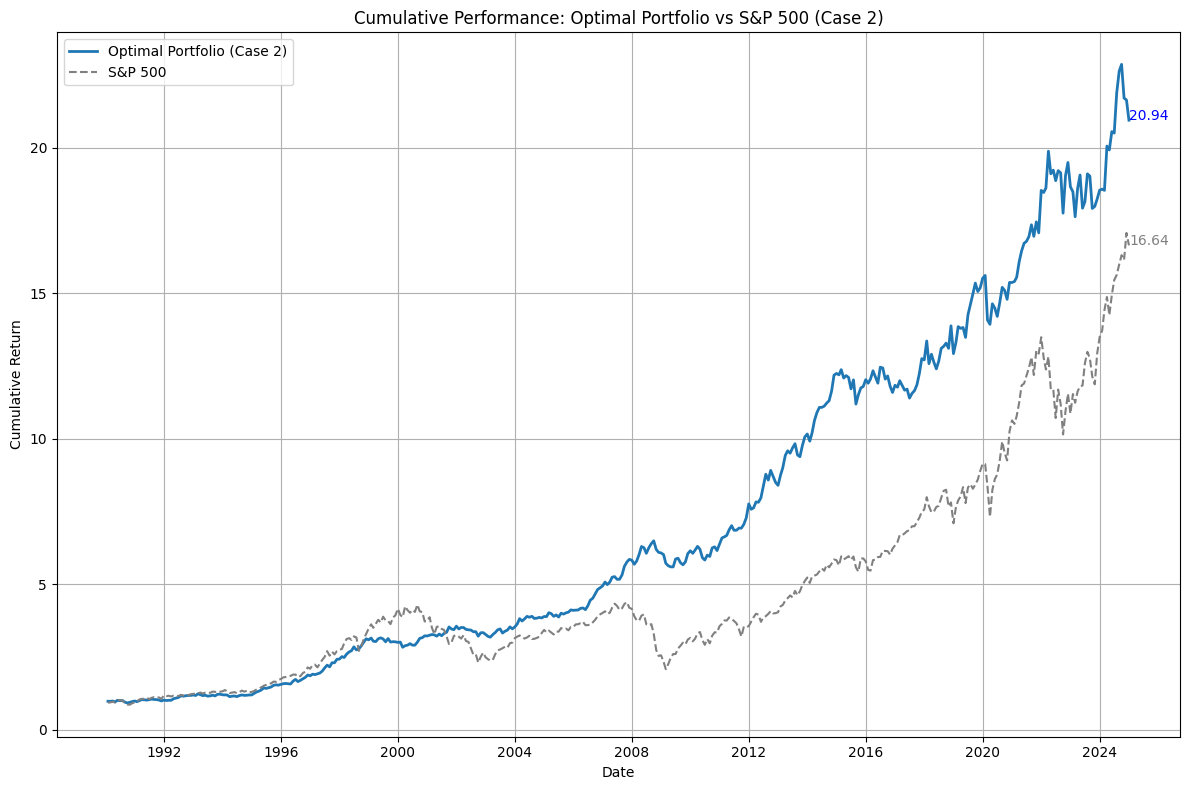

In [6]:
cum_opt = (1 + opt_ret_monthly).cumprod()
cum_sp = (1 + msp500['spret']).cumprod()

plt.figure(figsize=(12, 8))
plt.plot(cum_opt.index, cum_opt, label='Optimal Portfolio (Case 2)', linewidth=2)
plt.plot(cum_sp.index, cum_sp, label='S&P 500', linestyle='--', color='gray')

plt.text(cum_opt.index[-1], cum_opt.iloc[-1], f"{cum_opt.iloc[-1]:.2f}", color='blue', fontsize=10)
plt.text(cum_sp.index[-1], cum_sp.iloc[-1], f"{cum_sp.iloc[-1]:.2f}", color='gray', fontsize=10)

plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Performance: Optimal Portfolio vs S&P 500 (Case 2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#2-(a)

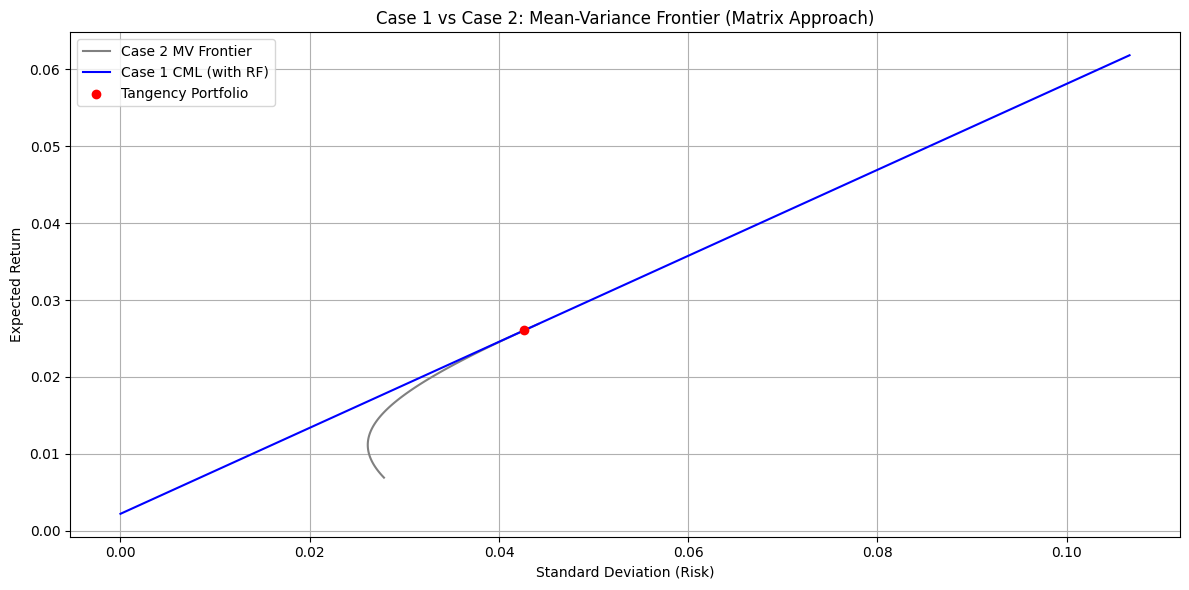

In [7]:
# 데이터 불러오기
msf = pd.read_csv("msf.csv")
msp500 = pd.read_csv("msp500_risk_free.csv")
msf['mdate'] = pd.to_datetime(msf['mdate'])
msp500['mdate'] = pd.to_datetime(msp500['mdate'])

# 수익률 피벗
pivot_ret = msf.pivot(index='mdate', columns='permno', values='ret').dropna(axis=1)
common_dates = pivot_ret.index.intersection(msp500['mdate'])
pivot_ret = pivot_ret.loc[common_dates]
msp500 = msp500.set_index('mdate').loc[common_dates]

# 변수 정의
mu = pivot_ret.mean().values            # 평균 수익률 벡터
Sigma = pivot_ret.cov().values          # 공분산 행렬
rf = msp500['rf'].mean()                # 월간 무위험 수익률
ones = np.ones(len(mu))
inv_Sigma = np.linalg.inv(Sigma)

# Case 1: Tangency 포트폴리오
excess_mu = mu - rf * ones
top = inv_Sigma @ excess_mu
bottom = ones.T @ top
w_tan = top / bottom

mu_tan = mu @ w_tan
sigma_tan = np.sqrt(w_tan.T @ Sigma @ w_tan)
slope = (mu_tan - rf) / sigma_tan

# Case 2: MV Frontier 계산
def mv_frontier_case2(mu, Sigma):
    inv_Sigma = np.linalg.inv(Sigma)
    ones = np.ones(len(mu))
    A = ones.T @ inv_Sigma @ ones
    B = ones.T @ inv_Sigma @ mu
    C = mu.T @ inv_Sigma @ mu
    Delta = A * C - B**2

    frontier_mu = np.linspace(mu.min(), mu.max(), 100)
    frontier_vol = []

    for r_p in frontier_mu:
        gamma = (r_p * A - B) / Delta
        lamb = (C - r_p * B) / Delta
        w = inv_Sigma @ (lamb * ones + gamma * mu)
        std = np.sqrt(w.T @ Sigma @ w)
        frontier_vol.append(std)

    return frontier_vol, frontier_mu

mv_vols, mv_rets = mv_frontier_case2(mu, Sigma)

# Case 1: 자본시장선 (CML)
sigma_vals = np.linspace(0, sigma_tan * 2.5, 100)
cml = rf + slope * sigma_vals

# 그래프 출력
plt.figure(figsize=(12, 6))
plt.plot(mv_vols, mv_rets, label='Case 2 MV Frontier', color='gray')
plt.plot(sigma_vals, cml, label='Case 1 CML (with RF)', color='blue')
plt.scatter(sigma_tan, mu_tan, color='red', label='Tangency Portfolio', zorder=5)
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Expected Return")
plt.title("Case 1 vs Case 2: Mean-Variance Frontier (Matrix Approach)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
slope = (mu_tan - rf) / sigma_tan
print(f"CML Slope (Sharpe Ratio of Tangency Portfolio): {slope:.6f}")

CML Slope (Sharpe Ratio of Tangency Portfolio): 0.559278


# 2-(b)

In [8]:
# Tangency 포트폴리오 계산
excess_mu = mu - rf * ones
top = inv_Sigma @ excess_mu
bottom = ones.T @ top
w_tan = top / bottom
mu_tan = mu @ w_tan

# 목표 수익률을 달성하기 위한 주식 비중 x
mu_sp = msp500['spret'].mean()
x = (mu_sp - rf) / (mu_tan - rf)
w_final = x * w_tan
rf_weight = 1 - x

# 특정 종목 및 무위험 자산
permno_to_name = msf[['permno', 'comnam']].drop_duplicates().set_index('permno')['comnam'].to_dict()
target_permnos = [22592, 59408, 61241, 14593, 43449]

print("=== Case 1 최적 포트폴리오 (Matrix Approach) ===")
for permno in target_permnos:
    if permno in pivot_ret.columns:
        idx = list(pivot_ret.columns).index(permno)
        print(f"{permno_to_name.get(permno, 'Unknown')} ({permno}): {w_final[idx]:.4%}")
print(f"무위험 자산 비중 (risk-free asset): {rf_weight:.4%}")

=== Case 1 최적 포트폴리오 (Matrix Approach) ===
3M CO (22592): 0.9343%
BANK OF AMERICA CORP (59408): -1.6051%
ADVANCED MICRO DEVICES INC (61241): -0.3344%
APPLE INC (14593): 1.9935%
MCDONALDS CORP (43449): 0.8285%
무위험 자산 비중 (risk-free asset): 77.1915%


# 2-(c)

In [9]:
# ---------------------------
# Case 1 포트폴리오 조정 (S&P500 초과수익률과 동일하게 맞춤)
# ---------------------------

# Tangency 포트폴리오 초과수익률 (월별)
excess_risky_case1 = (pivot_ret @ w_tan) - rf

# S&P500 초과수익률 (월별)
excess_sp = msp500['spret'] - msp500['rf']

# 평균 초과수익률 계산
mean_excess_risky = excess_risky_case1.mean()
mean_excess_sp = excess_sp.mean()

# Tangency 포트폴리오 스케일링 비율 x_matched 계산
x_matched = mean_excess_sp / mean_excess_risky

# 조정된 포트폴리오 수익률 및 초과수익률
adj_port_ret_case1 = x_matched * (pivot_ret @ w_tan) + (1 - x_matched) * rf
adj_excess_case1 = adj_port_ret_case1 - msp500['rf']

# 월간 변동성 및 S&P500 변동성
std_case1 = adj_port_ret_case1.std()
std_sp = msp500['spret'].std()

# ---------------------------
# 연환산 기준 테이블 구성
# ---------------------------
ans2c = pd.DataFrame(
    [
        [mean_excess_sp * 12 * 100, mean_excess_sp * 12 * 100],             # 동일한 초과수익률
        [std_case1 * np.sqrt(12) * 100, std_sp * np.sqrt(12) * 100],        # Volatility (%)
        [(mean_excess_sp / std_case1) * np.sqrt(12),
         (mean_excess_sp / std_sp) * np.sqrt(12)]                           # Sharpe Ratio
    ],
    columns=['Optimal Portfolio (Case 1)', 'S&P 500'],
    index=['Excess Return (%)', 'Volatility (%)', 'Sharpe Ratio']
)

# ---------------------------
# 기존 1-c 결과 (Case 2) 추가하여 비교 테이블 만들기
# ---------------------------
case2_results = comparison1_df['Optimal Portfolio (Case 2)']

comparison2_df = pd.DataFrame({
    'Case 1 (Optimal)': ans2c['Optimal Portfolio (Case 1)'],
    'Case 2 (Optimal)': case2_results,
    'S&P 500': ans2c['S&P 500']
})

display(comparison2_df)

,Case 1 (Optimal),Case 2 (Optimal),S&P 500
Excess Return (%),6.529617,6.529617,6.529617
Volatility (%),3.370308,9.462050,14.814414
Sharpe Ratio,1.937394,0.690085,0.440761


# 2-(d)

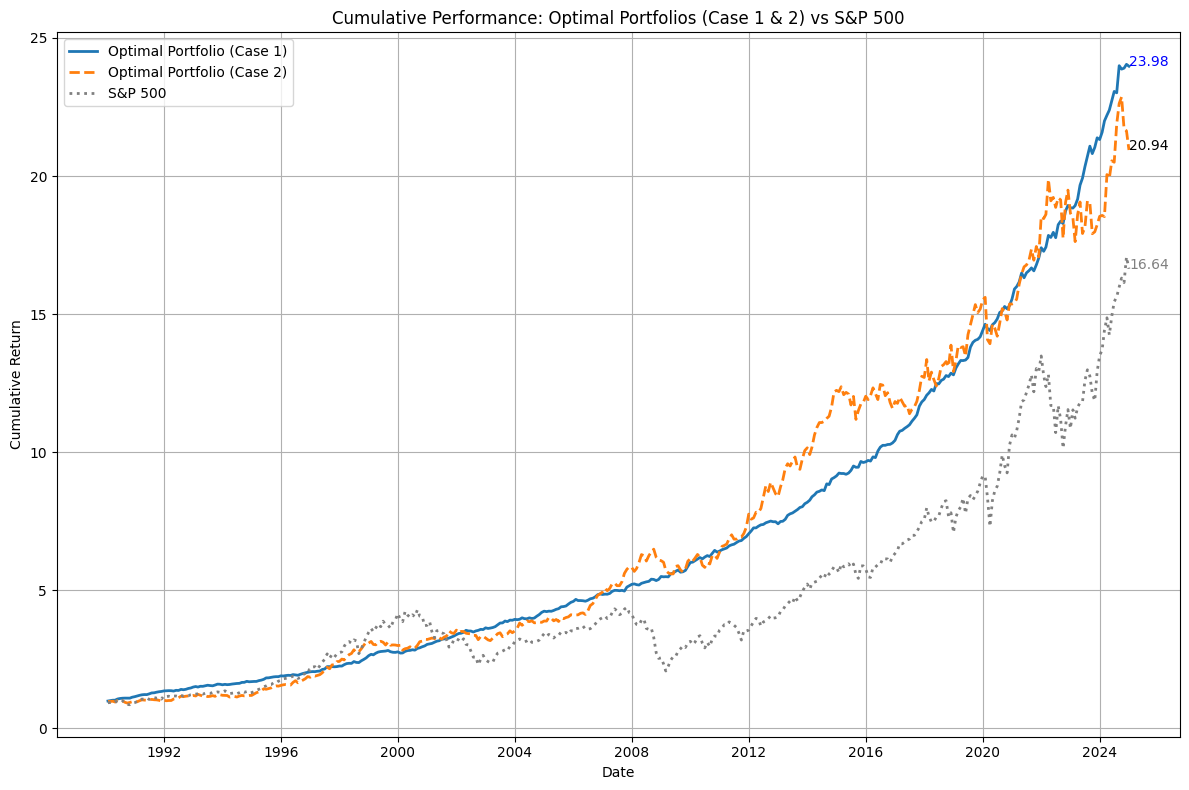

In [10]:
# 누적 수익률 계산 (통일된 변수명)
cum_case1 = (1 + adj_port_ret_case1).cumprod()             # Case 1 (Tangency + RF)
cum_opt = (1 + opt_ret_monthly).cumprod()                  # Case 2 (기존 1-d와 동일)
cum_sp = (1 + msp500['spret']).cumprod()                   # S&P 500

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# 동일한 스타일로 통일
plt.plot(cum_case1.index, cum_case1, label='Optimal Portfolio (Case 1)', linewidth=2)
plt.plot(cum_opt.index, cum_opt, label='Optimal Portfolio (Case 2)', linestyle='--', linewidth=2)
plt.plot(cum_sp.index, cum_sp, label='S&P 500', linestyle=':', color='gray', linewidth=2)

# 최종 수익률 텍스트 표시
plt.text(cum_case1.index[-1], cum_case1.iloc[-1], f"{cum_case1.iloc[-1]:.2f}", color='blue', fontsize=10)
plt.text(cum_opt.index[-1], cum_opt.iloc[-1], f"{cum_opt.iloc[-1]:.2f}", color='black', fontsize=10)
plt.text(cum_sp.index[-1], cum_sp.iloc[-1], f"{cum_sp.iloc[-1]:.2f}", color='gray', fontsize=10)

# 제목 등
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Performance: Optimal Portfolios (Case 1 & 2) vs S&P 500")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3-(a)

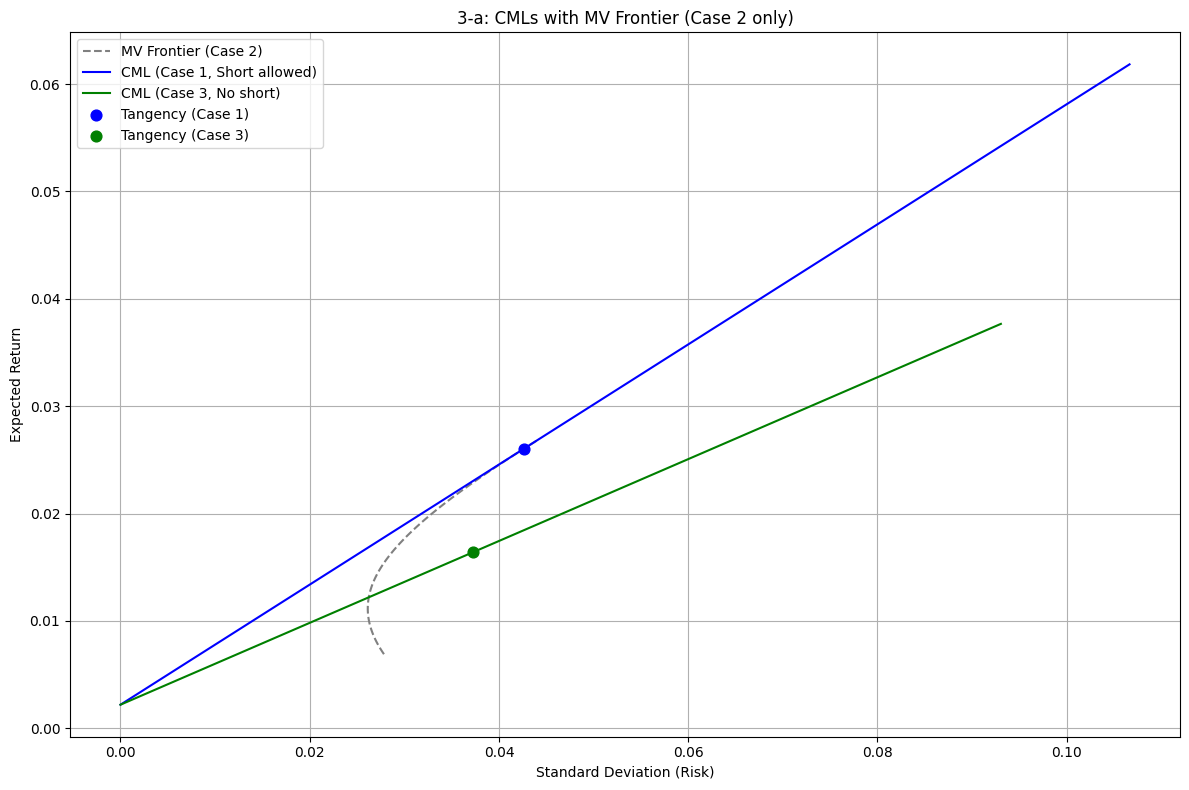

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ---------------------------
# 데이터 로딩
# ---------------------------
msf = pd.read_csv("msf.csv")
msp500 = pd.read_csv("msp500_risk_free.csv")
msf['mdate'] = pd.to_datetime(msf['mdate'])
msp500['mdate'] = pd.to_datetime(msp500['mdate'])

pivot_ret = msf.pivot(index='mdate', columns='permno', values='ret').dropna(axis=1)
common_dates = pivot_ret.index.intersection(msp500['mdate'])
pivot_ret = pivot_ret.loc[common_dates]
msp500 = msp500.set_index('mdate').loc[common_dates]

# ---------------------------
# 변수 설정
# ---------------------------
mu = pivot_ret.mean().values
Sigma = pivot_ret.cov().values
rf = msp500['rf'].mean()
ones = np.ones(len(mu))
inv_Sigma = np.linalg.inv(Sigma)

# ---------------------------
# Case 1: Tangency (Short allowed)
# ---------------------------
excess_mu = mu - rf * ones
w_tan_1 = inv_Sigma @ excess_mu / (ones.T @ inv_Sigma @ excess_mu)
mu_tan_1 = mu @ w_tan_1
sigma_tan_1 = np.sqrt(w_tan_1.T @ Sigma @ w_tan_1)
slope_1 = (mu_tan_1 - rf) / sigma_tan_1

# ---------------------------
# Case 2: Mean-Variance Frontier (short allowed, no RF)
# ---------------------------
A = ones.T @ inv_Sigma @ ones
B = ones.T @ inv_Sigma @ mu
C = mu.T @ inv_Sigma @ mu
Delta = A * C - B**2

frontier_mu = np.linspace(mu.min(), mu.max(), 100)
frontier_vol = []
for r_p in frontier_mu:
    gamma = (r_p * A - B) / Delta
    lamb = (C - r_p * B) / Delta
    w = inv_Sigma @ (lamb * ones + gamma * mu)
    std = np.sqrt(w.T @ Sigma @ w)
    frontier_vol.append(std)

# ---------------------------
# Case 3: Tangency (No short-selling)
# ---------------------------
def negative_sharpe(w, mu, Sigma, rf):
    ret = w @ mu
    vol = np.sqrt(w.T @ Sigma @ w)
    return -(ret - rf) / vol

constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
bounds = [(0, 1)] * len(mu)
init_w = np.ones(len(mu)) / len(mu)

result = minimize(negative_sharpe, init_w, args=(mu, Sigma, rf),
                  method='SLSQP', bounds=bounds, constraints=constraints,
                  options={'maxiter': 10000}, tol=1e-12)

w_tan_3 = result.x
mu_tan_3 = mu @ w_tan_3
sigma_tan_3 = np.sqrt(w_tan_3.T @ Sigma @ w_tan_3)
slope_3 = (mu_tan_3 - rf) / sigma_tan_3

# ---------------------------
# CML 계산
# ---------------------------
sigma_vals_1 = np.linspace(0, sigma_tan_1 * 2.5, 100)
cml_1 = rf + slope_1 * sigma_vals_1
sigma_vals_3 = np.linspace(0, sigma_tan_3 * 2.5, 100)
cml_3 = rf + slope_3 * sigma_vals_3

# ---------------------------
# 시각화
# ---------------------------
plt.figure(figsize=(12, 8))

# Case 2 MV Frontier
plt.plot(frontier_vol, frontier_mu, '--', color='gray', label='MV Frontier (Case 2)')

# CML Lines
plt.plot(sigma_vals_1, cml_1, color='blue', label='CML (Case 1, Short allowed)')
plt.plot(sigma_vals_3, cml_3, color='green', label='CML (Case 3, No short)')

# Tangency points
plt.scatter(sigma_tan_1, mu_tan_1, color='blue', s=60, label='Tangency (Case 1)', zorder=5)
plt.scatter(sigma_tan_3, mu_tan_3, color='green', s=60, label='Tangency (Case 3)', zorder=5)

# Plot formatting
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Expected Return")
plt.title("3-a: CMLs with MV Frontier (Case 2 only)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
print(f"Slope of CML (Case 1, Short allowed): {slope_1:.6f}")
print(f"Slope of CML (Case 3, No short): {slope_3:.6f}")

Slope of CML (Case 1, Short allowed): 0.559278
Slope of CML (Case 3, No short): 0.381223


# 3-(b)

In [12]:
def minimizing_vol(w):
    # w[0] = rf 비중, w[1:] = risky 자산 비중
    return w[1:].T @ Sigma @ w[1:]

# 제약조건 1: 총 투자 비중 = 1
def constraint_weight_sum(w):
    return np.sum(w) - 1

# 제약조건 2: 목표 수익률 (mu_sp) 달성
def constraint_target_ret(w):
    return w[0] * rf + w[1:].dot(mu) - mu_sp

constraints = [
    {'type': 'eq', 'fun': constraint_weight_sum},
    {'type': 'eq', 'fun': constraint_target_ret}
]

# ---------------------------
# 경계조건 설정
# ---------------------------
# w[0]: 무위험 자산 (제한 없음), w[1:]: risky 자산 (no short selling)
bounds = [(None, None)] + [(0, None)] * n

# ---------------------------
# 최적화 실행
# ---------------------------
init_guess = np.ones(n + 1) / (n + 1)
result = minimize(minimizing_vol,
                  init_guess,
                  method='SLSQP',
                  bounds=bounds,
                  constraints=constraints,
                  options={'maxiter': 10000},
                  tol=1e-12)

if not result.success:
    print("최적화 실패:", result.message)

# ---------------------------
# 결과 해석
# ---------------------------
w_opt = result.x
w_rf = w_opt[0]
w_risky = w_opt[1:]
w_total = w_opt

# ---------------------------
# 종목명 매핑 및 출력
# ---------------------------
permno_to_name = msf[['permno', 'comnam']].drop_duplicates().set_index('permno')['comnam'].to_dict()
target_permnos = [22592, 59408, 61241, 14593, 43449]

print("=== 최적 포트폴리오 (Case 3: No Short + RF) ===")
for permno in target_permnos:
    if permno in pivot_ret.columns:
        idx = list(pivot_ret.columns).index(permno)
        print(f"{permno_to_name.get(permno, 'Unknown')} ({permno}): {w_risky[idx]*100:.4f}%")

print(f"무위험 자산 비중 (Risk-Free Asset): {w_rf*100:.4f}%")

=== 최적 포트폴리오 (Case 3: No Short + RF) ===
3M CO (22592): 0.0000%
BANK OF AMERICA CORP (59408): 0.0000%
ADVANCED MICRO DEVICES INC (61241): 0.0000%
APPLE INC (14593): 2.6603%
MCDONALDS CORP (43449): 0.0000%
무위험 자산 비중 (Risk-Free Asset): 61.6471%


# 3-(c)

In [13]:
# ---------------------------
# Case 3: No Short + RF matched (std_case3 정의 포함)
# ---------------------------
# risky 포트폴리오 수익률
ret_risky_case3 = pivot_ret @ w_tan_3
excess_risky_case3 = ret_risky_case3 - rf

# 초과수익률 평균
mean_excess_risky3 = excess_risky_case3.mean()

# S&P500 초과수익률
excess_sp = msp500['spret'] - msp500['rf']
mean_excess_sp = excess_sp.mean()

# 스케일링 비율
x_matched_case3 = mean_excess_sp / mean_excess_risky3

# 조정된 포트폴리오 수익률
adj_ret_case3 = x_matched_case3 * ret_risky_case3 + (1 - x_matched_case3) * rf

# std_case3
std_case3 = adj_ret_case3.std()

# ---------------------------
# Case 1: MV with RF (Sharpe 최대)
# ---------------------------
excess_case1 = mean_excess_sp
vol_case1 = std_case1
sharpe_case1 = (excess_case1 / vol_case1) * np.sqrt(12)

# ---------------------------
# Case 2: MV without RF
excess_case2 = mean_ret_opt - rf_all
vol_case2 = std_ret_opt
sharpe_case2 = (excess_case2 / vol_case2) * np.sqrt(12)

# ---------------------------
# Case 3: matched version
excess_case3 = mean_excess_sp
vol_case3 = std_case3
sharpe_case3 = (excess_case3 / vol_case3) * np.sqrt(12)

# ---------------------------
# S&P 500
vol_sp = msp500['spret'].std()
sharpe_sp = (mean_excess_sp / vol_sp) * np.sqrt(12)

# ---------------------------
# 연환산 변환 함수
def ann(x): return x * 12 * 100
def ann_std(x): return x * np.sqrt(12) * 100


comparison3_df = pd.DataFrame(
    [
        [ann(excess_case1), ann(excess_case2), ann(excess_case3), ann(mean_excess_sp)],
        [ann_std(vol_case1), ann_std(vol_case2), ann_std(vol_case3), ann_std(vol_sp)],
        [sharpe_case1, sharpe_case2, sharpe_case3, sharpe_sp]
    ],
    columns=['MV Case 1', 'MV Case 2', 'MV Case 3', 'S&P 500'],
    index=['Excess Return (%)', 'Volatility (%)', 'Sharpe Ratio']
)

comparison3_df


,MV Case 1,MV Case 2,MV Case 3,S&P 500
Excess Return (%),6.529617,6.529617,6.529617,6.529617
Volatility (%),3.370308,9.462050,4.944451,14.814414
Sharpe Ratio,1.937394,0.690085,1.320595,0.440761


# 3-(d)

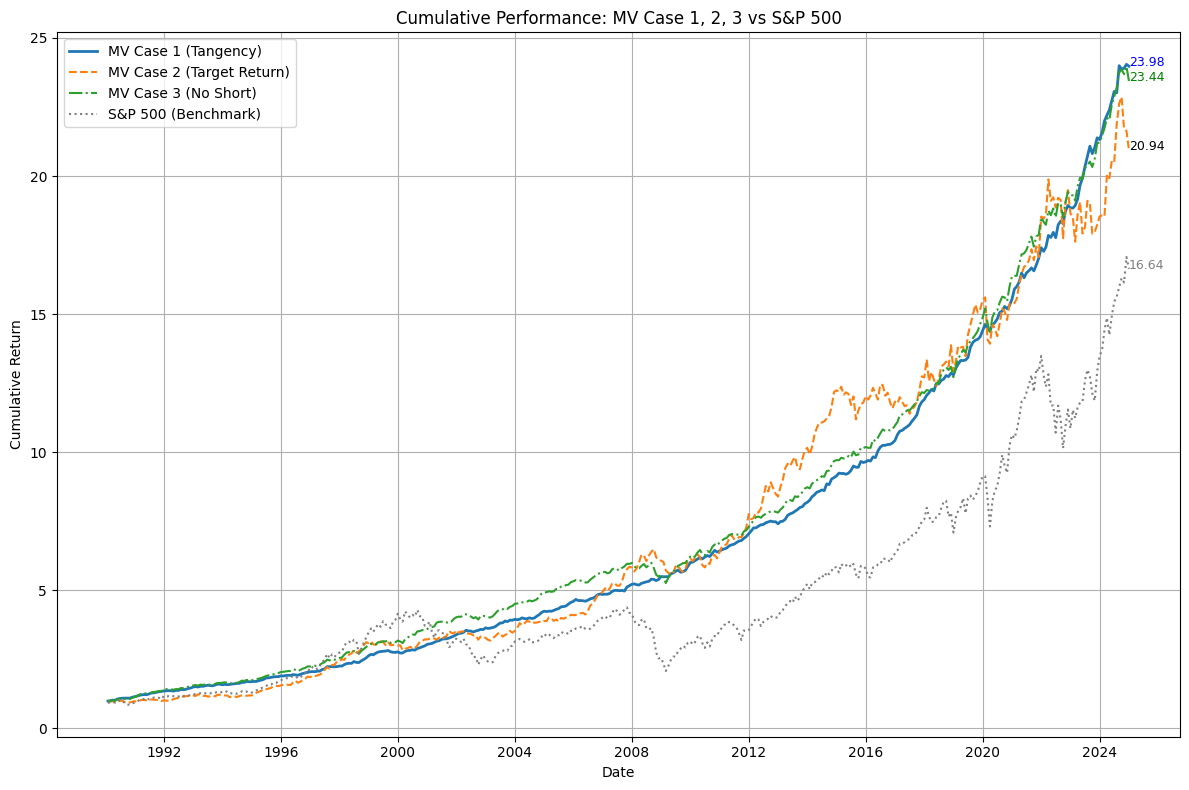

In [14]:
# Case 1 누적 수익률 (2-c 방식 → 초과수익률 matched version 사용)
ret_risky_case1 = pivot_ret @ w_tan  # from case 1
adj_ret_case1 = x_matched * ret_risky_case1 + (1 - x_matched) * rf  # x_matched = S&P와 맞춘 비중
cum_case1 = (1 + adj_ret_case1).cumprod()

# ---------------------------
# Case 2 누적 수익률
cum_case2 = (1 + opt_ret_monthly).cumprod()

# ---------------------------
# Case 3 누적 수익률 (3-c에서 만든 matched version)
ret_risky_case3 = pivot_ret @ w_tan_3
adj_ret_case3 = x_matched_case3 * ret_risky_case3 + (1 - x_matched_case3) * rf
cum_case3 = (1 + adj_ret_case3).cumprod()

# ---------------------------
# Benchmark (S&P 500)
cum_sp = (1 + msp500['spret']).cumprod()

# ---------------------------
# Plotting
# ---------------------------
plt.figure(figsize=(12, 8))

plt.plot(cum_case1.index, cum_case1, label='MV Case 1 (Tangency)', linewidth=2)
plt.plot(cum_case2.index, cum_case2, label='MV Case 2 (Target Return)', linestyle='--')
plt.plot(cum_case3.index, cum_case3, label='MV Case 3 (No Short)', linestyle='-.')
plt.plot(cum_sp.index, cum_sp, label='S&P 500 (Benchmark)', linestyle=':', color='gray')

# 최종 수익률 수치 표시
plt.text(cum_case1.index[-1], cum_case1.iloc[-1], f"{cum_case1.iloc[-1]:.2f}", color='blue', fontsize=9)
plt.text(cum_case2.index[-1], cum_case2.iloc[-1], f"{cum_case2.iloc[-1]:.2f}", color='black', fontsize=9)
plt.text(cum_case3.index[-1], cum_case3.iloc[-1], f"{cum_case3.iloc[-1]:.2f}", color='green', fontsize=9)
plt.text(cum_sp.index[-1], cum_sp.iloc[-1], f"{cum_sp.iloc[-1]:.2f}", color='gray', fontsize=9)

# 레이블 등 설정
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Performance: MV Case 1, 2, 3 vs S&P 500")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#4-(a)

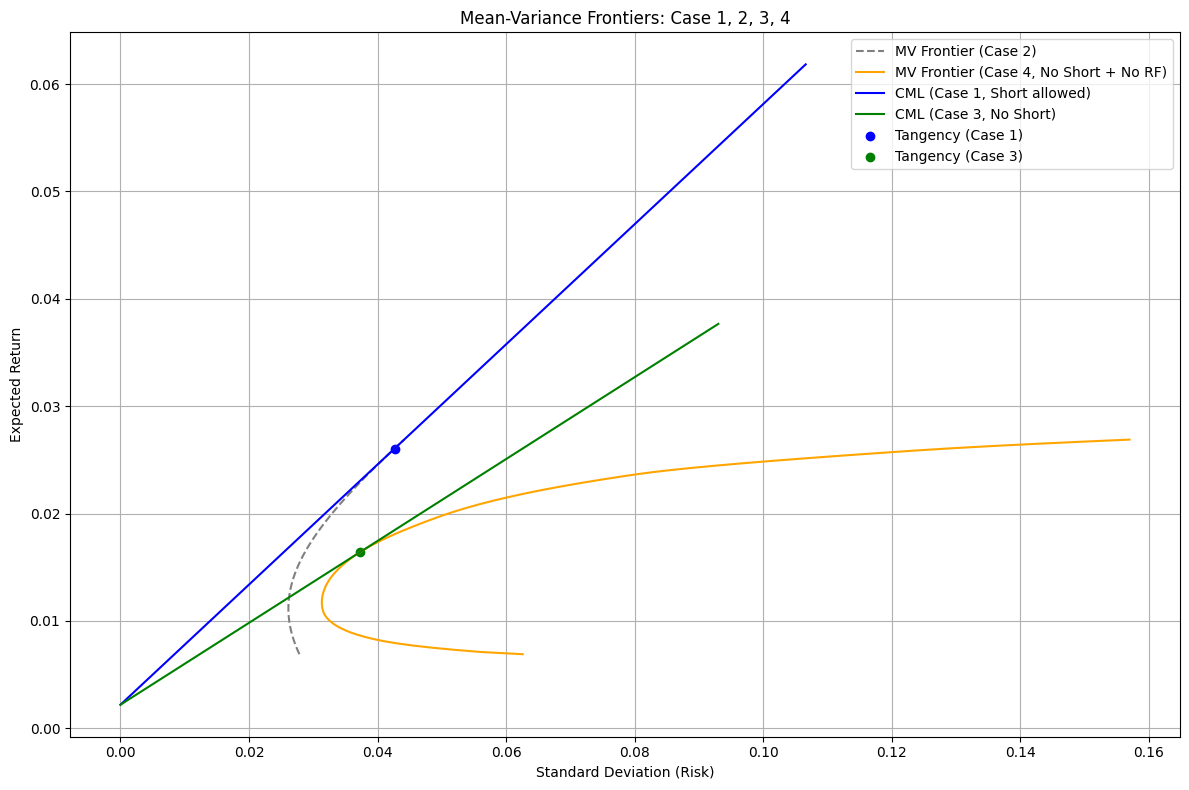

In [15]:
def min_var_case4(target_return, mu, Sigma):
    n_assets = len(mu)
    init_w = np.ones(n_assets) / n_assets
    bounds = [(0, 1)] * n_assets
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: w @ mu - target_return}
    ]
    result = minimize(lambda w: w.T @ Sigma @ w, init_w, method='SLSQP',
                      bounds=bounds, constraints=constraints,
                      options={'maxiter': 10000}, tol=1e-10)
    if result.success:
        return np.sqrt(result.fun)
    else:
        return np.nan  # 실패 시 NaN 처리

# ---------------------------
# Case 4 프론티어 계산
# ---------------------------
target_returns_4 = np.linspace(mu.min(), mu.max(), 100)
frontier_std_4 = [min_var_case4(r, mu, Sigma) for r in target_returns_4]

# Case 1: CML (tangency with RF)
sigma_vals_1 = np.linspace(0, sigma_tan_1 * 2.5, 100)
cml_1 = rf + slope_1 * sigma_vals_1

# Case 3: CML with no short
sigma_vals_3 = np.linspace(0, sigma_tan_3 * 2.5, 100)
cml_3 = rf + slope_3 * sigma_vals_3

# ---------------------------
# 그래프 그리기
# ---------------------------
plt.figure(figsize=(12, 8))

# Case 2: MV Frontier (gray dashed)
plt.plot(frontier_vol, frontier_mu, '--', color='gray', label='MV Frontier (Case 2)')

# Case 4: MV Frontier (no RF, no short)
plt.plot(frontier_std_4, target_returns_4, '-', color='orange', label='MV Frontier (Case 4, No Short + No RF)')

# Case 1: CML
plt.plot(sigma_vals_1, cml_1, label='CML (Case 1, Short allowed)', color='blue')

# Case 3: CML
plt.plot(sigma_vals_3, cml_3, label='CML (Case 3, No Short)', color='green')

# Tangency points
plt.scatter(sigma_tan_1, mu_tan_1, color='blue', label='Tangency (Case 1)')
plt.scatter(sigma_tan_3, mu_tan_3, color='green', label='Tangency (Case 3)')

plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Expected Return")
plt.title("Mean-Variance Frontiers: Case 1, 2, 3, 4")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 4-(b)

In [16]:
mu_sp = msp500['spret'].mean()  # S&P 500 평균 수익률

# ---------------------------
# 최적화 설정 (no RF, no short)
# ---------------------------
n_assets = len(mu)
init_w = np.ones(n_assets) / n_assets

bounds = [(0, 1)] * n_assets
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # 총합 1
    {'type': 'eq', 'fun': lambda w: w @ mu - mu_sp}  # 기대수익률 맞춤
]

# ---------------------------
# 리스크 최소화 최적화
# ---------------------------
def portfolio_variance(w, Sigma):
    return w.T @ Sigma @ w

result = minimize(portfolio_variance, init_w, args=(Sigma,),
                  method='SLSQP', bounds=bounds, constraints=constraints,
                  options={'maxiter': 10000}, tol=1e-12)

if not result.success:
    raise ValueError("최적화 실패: " + result.message)

w_case4 = result.x

# ---------------------------
# 특정 종목 비중 출력
# ---------------------------
target_permnos = [22592, 59408, 61241, 14593, 43449]
permno_to_name = msf[['permno', 'comnam']].drop_duplicates().set_index('permno')['comnam'].to_dict()

print("=== Case 4 최적 포트폴리오 비중 (No RF, No Short) ===")
for permno in target_permnos:
    if permno in pivot_ret.columns:
        idx = list(pivot_ret.columns).index(permno)
        print(f"{permno_to_name.get(permno, 'Unknown')} ({permno}): {w_case4[idx] * 100:.6f}%")


=== Case 4 최적 포트폴리오 비중 (No RF, No Short) ===
3M CO (22592): 4.344219%
BANK OF AMERICA CORP (59408): 0.000000%
ADVANCED MICRO DEVICES INC (61241): 0.000000%
APPLE INC (14593): 0.000000%
MCDONALDS CORP (43449): 0.000000%


# 4-(c)

In [17]:
ret_case4 = pivot_ret @ w_case4                # risky-only 수익률
excess_case4 = ret_case4 - msp500['rf']        # 초과 수익률

mean_case4 = excess_case4.mean()
std_case4 = ret_case4.std()
sharpe_case4 = (mean_case4 / std_case4) * np.sqrt(12)

# ---------------------------
# Benchmark (S&P500)
# ---------------------------
mean_sp = mean_excess_sp                       # 동일
std_sp = msp500['spret'].std()
sharpe_sp = (mean_sp / std_sp) * np.sqrt(12)

# ---------------------------
# 연환산 환산 함수
# ---------------------------
def ann(x): return x * 12 * 100
def ann_std(x): return x * np.sqrt(12) * 100

# Case 1
excess_case1 = mean_excess_sp
vol_case1 = std_case1
sharpe_case1 = (excess_case1 / vol_case1) * np.sqrt(12)

# Case 2
excess_case2 = mean_ret_opt - rf_all
vol_case2 = std_ret_opt
sharpe_case2 = (excess_case2 / vol_case2) * np.sqrt(12)

# Case 3
excess_case3 = mean_excess_sp
vol_case3 = std_case3
sharpe_case3 = (excess_case3 / vol_case3) * np.sqrt(12)


comparison4_df = pd.DataFrame(
    [
        [ann(excess_case1), ann(excess_case2), ann(excess_case3), ann(mean_case4), ann(mean_sp)],
        [ann_std(vol_case1), ann_std(vol_case2), ann_std(vol_case3), ann_std(std_case4), ann_std(std_sp)],
        [sharpe_case1, sharpe_case2, sharpe_case3, sharpe_case4, sharpe_sp]
    ],
    columns=['MV Case 1', 'MV Case 2', 'MV Case 3', 'MV Case 4', 'S&P 500'],
    index=['Excess Return (%)', 'Volatility (%)', 'Sharpe Ratio']
)


comparison4_df

,MV Case 1,MV Case 2,MV Case 3,MV Case 4,S&P 500
Excess Return (%),6.529617,6.529617,6.529617,6.529617,6.529617
Volatility (%),3.370308,9.462050,4.944451,16.104665,14.814414
Sharpe Ratio,1.937394,0.690085,1.320595,0.405449,0.440761


# 4-(d)

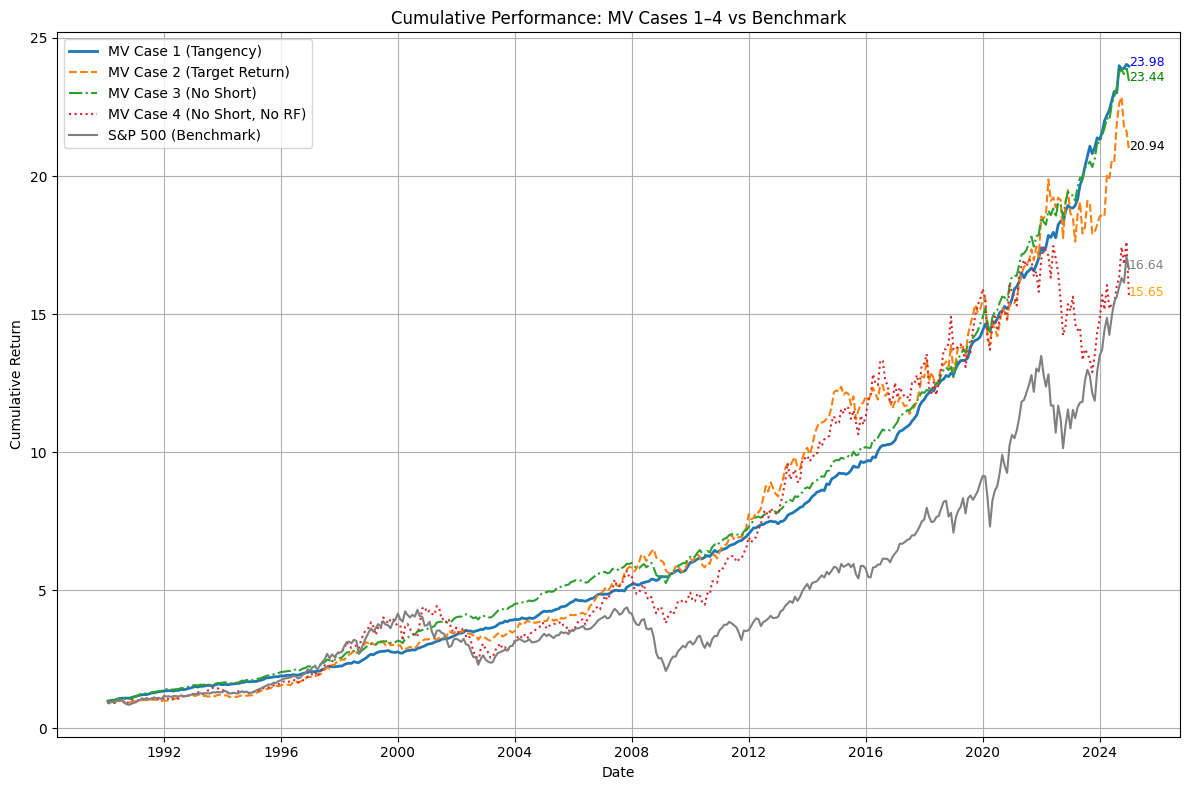

In [18]:
# Case 1
ret_risky_case1 = pivot_ret @ w_tan
adj_ret_case1 = x_matched * ret_risky_case1 + (1 - x_matched) * rf
cum_case1 = (1 + adj_ret_case1).cumprod()

# Case 2
cum_case2 = (1 + opt_ret_monthly).cumprod()

# Case 3
ret_risky_case3 = pivot_ret @ w_tan_3
adj_ret_case3 = x_matched_case3 * ret_risky_case3 + (1 - x_matched_case3) * rf
cum_case3 = (1 + adj_ret_case3).cumprod()

# Case 4
ret_case4 = pivot_ret @ w_case4
cum_case4 = (1 + ret_case4).cumprod()

# Benchmark (S&P 500)
cum_sp = (1 + msp500['spret']).cumprod()

# ---------------------------
# 누적 수익률 그래프
# ---------------------------
plt.figure(figsize=(12, 8))

plt.plot(cum_case1.index, cum_case1, label='MV Case 1 (Tangency)', linewidth=2)
plt.plot(cum_case2.index, cum_case2, label='MV Case 2 (Target Return)', linestyle='--')
plt.plot(cum_case3.index, cum_case3, label='MV Case 3 (No Short)', linestyle='-.')
plt.plot(cum_case4.index, cum_case4, label='MV Case 4 (No Short, No RF)', linestyle=':')
plt.plot(cum_sp.index, cum_sp, label='S&P 500 (Benchmark)', linestyle='-', color='gray')

# 최종 수익률 숫자 표시
plt.text(cum_case1.index[-1], cum_case1.iloc[-1], f"{cum_case1.iloc[-1]:.2f}", color='blue', fontsize=9)
plt.text(cum_case2.index[-1], cum_case2.iloc[-1], f"{cum_case2.iloc[-1]:.2f}", color='black', fontsize=9)
plt.text(cum_case3.index[-1], cum_case3.iloc[-1], f"{cum_case3.iloc[-1]:.2f}", color='green', fontsize=9)
plt.text(cum_case4.index[-1], cum_case4.iloc[-1], f"{cum_case4.iloc[-1]:.2f}", color='orange', fontsize=9)
plt.text(cum_sp.index[-1], cum_sp.iloc[-1], f"{cum_sp.iloc[-1]:.2f}", color='gray', fontsize=9)

plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Performance: MV Cases 1–4 vs Benchmark")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 5-(a)

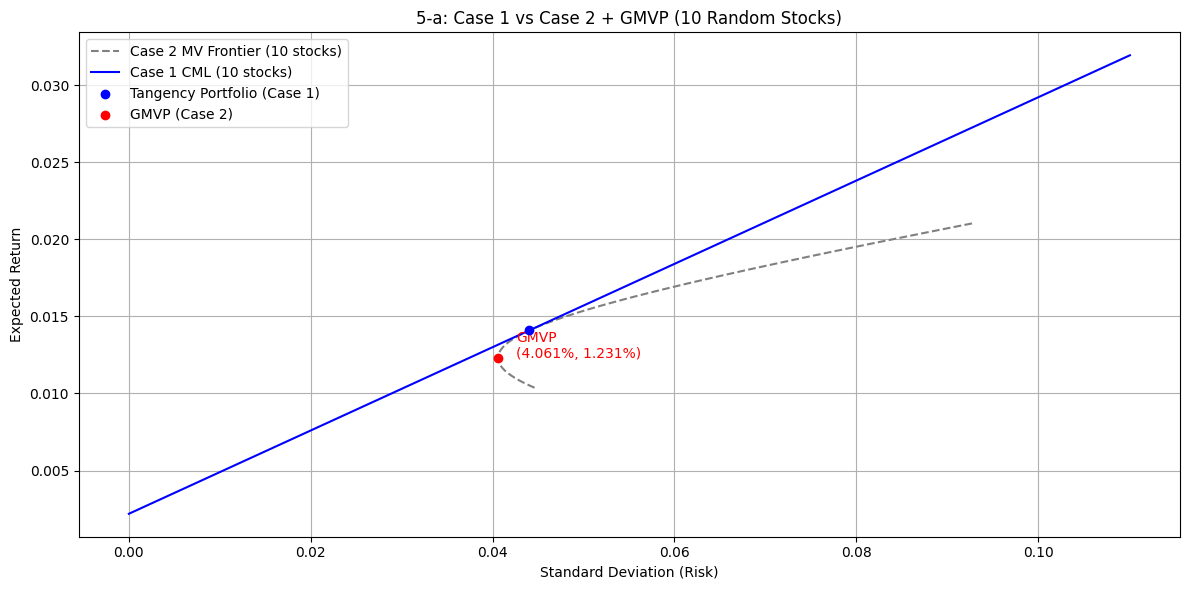

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ---------------------------
# 무작위 종목 10개 선택
# ---------------------------
np.random.seed(42)
random_stocks_index = np.random.choice(pivot_ret.shape[1], 10, replace=False)
selected_columns = pivot_ret.columns[random_stocks_index]
ret_10 = pivot_ret[selected_columns]

mu_10 = ret_10.mean().values
Sigma_10 = ret_10.cov().values
rf_10 = msp500['rf'].mean()
ones_10 = np.ones(len(mu_10))
inv_Sigma_10 = np.linalg.inv(Sigma_10)

# ---------------------------
# Case 1: Tangency 포트폴리오
# ---------------------------
excess_mu_10 = mu_10 - rf_10 * ones_10
top = inv_Sigma_10 @ excess_mu_10
bottom = ones_10.T @ top
w_tan_10 = top / bottom

mu_tan_10 = mu_10 @ w_tan_10
sigma_tan_10 = np.sqrt(w_tan_10.T @ Sigma_10 @ w_tan_10)
slope_10 = (mu_tan_10 - rf_10) / sigma_tan_10

# CML
sigma_vals_10 = np.linspace(0, sigma_tan_10 * 2.5, 100)
cml_10 = rf_10 + slope_10 * sigma_vals_10

# ---------------------------
# Case 2: MV Frontier
# ---------------------------
A = ones_10.T @ inv_Sigma_10 @ ones_10
B = ones_10.T @ inv_Sigma_10 @ mu_10
C = mu_10.T @ inv_Sigma_10 @ mu_10
Delta = A * C - B**2

target_returns = np.linspace(mu_10.min(), mu_10.max(), 100)
mv_std_10 = []

for r in target_returns:
    gamma = (r * A - B) / Delta
    lam = (C - r * B) / Delta
    w = inv_Sigma_10 @ (lam * ones_10 + gamma * mu_10)
    std = np.sqrt(w.T @ Sigma_10 @ w)
    mv_std_10.append(std)

# ---------------------------
# GMVP (Global Minimum Variance Portfolio)
# ---------------------------
w_gmv_10 = inv_Sigma_10 @ ones_10 / (ones_10.T @ inv_Sigma_10 @ ones_10)
ret_gmv_10 = mu_10 @ w_gmv_10
vol_gmv_10 = np.sqrt(w_gmv_10.T @ Sigma_10 @ w_gmv_10)

# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(12, 6))

# MV Frontier
plt.plot(mv_std_10, target_returns, '--', color='gray', label='Case 2 MV Frontier (10 stocks)')

# CML (Tangency Line)
plt.plot(sigma_vals_10, cml_10, color='blue', label='Case 1 CML (10 stocks)')

# Tangency 포트폴리오
plt.scatter(sigma_tan_10, mu_tan_10, color='blue', label='Tangency Portfolio (Case 1)', zorder=5)

# GMVP
plt.scatter(vol_gmv_10, ret_gmv_10, color='red', label='GMVP (Case 2)', zorder=5)
plt.text(vol_gmv_10 + 0.002, ret_gmv_10,
         f'GMVP\n({vol_gmv_10:.3%}, {ret_gmv_10:.3%})',
         color='red', fontsize=10)

# 그래프 서식
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Expected Return")
plt.title("5-a: Case 1 vs Case 2 + GMVP (10 Random Stocks)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# 초과수익률
excess_risky_10 = ret_10 @ w_tan_10 - rf_10

# S&P500 초과수익률 평균
mean_excess_sp = (msp500['spret'] - msp500['rf']).mean()

# 스케일링 계수
x_matched_case1_10 = mean_excess_sp / excess_risky_10.mean()

# 조정된 월간 수익률
adj_ret_case1_10 = x_matched_case1_10 * (ret_10 @ w_tan_10) + (1 - x_matched_case1_10) * rf_10
std_case1_10 = adj_ret_case1_10.std()
# 연환산 초과수익률 (%)
excess_return_random = mean_excess_sp * 12 * 100

# 연환산 변동성 (%)
volatility_random = std_case1_10 * np.sqrt(12) * 100

# 연환산 Sharpe 비율
sharpe_random = (mean_excess_sp / std_case1_10) * np.sqrt(12)

# 무작위 포트폴리오 결과 시리즈 생성
random10_results = pd.Series(
    [excess_return_random, volatility_random, sharpe_random],
    index=['Excess Return (%)', 'Volatility (%)', 'Sharpe Ratio']
)

In [21]:
# ---------------------------
# Random 10 Stocks - Case 1 결과
# ---------------------------
excess_return_case1 = mean_excess_sp * 12 * 100
volatility_case1 = std_case1_10 * np.sqrt(12) * 100
sharpe_case1 = (mean_excess_sp / std_case1_10) * np.sqrt(12)

case1_series = pd.Series(
    [excess_return_case1, volatility_case1, sharpe_case1],
    index=['Excess Return (%)', 'Volatility (%)', 'Sharpe Ratio'],
    name='Random 10 Stocks (Case 1)'
)

# ---------------------------
# Random 10 Stocks - Case 2 (Matrix Approach)
# ---------------------------
# 1. A, B, C, Δ
A_10 = ones_10.T @ inv_Sigma_10 @ ones_10
B_10 = ones_10.T @ inv_Sigma_10 @ mu_10
C_10 = mu_10.T @ inv_Sigma_10 @ mu_10
Delta_10 = A_10 * C_10 - B_10**2

# 2. mu_p 기반 최적화
mu_p = msp500['spret'].mean()
gamma_10 = (mu_p * A_10 - B_10) / Delta_10
lambda_10 = (C_10 - mu_p * B_10) / Delta_10
w_mv_case2_10 = inv_Sigma_10 @ (lambda_10 * ones_10 + gamma_10 * mu_10)

# 3. 수익률 계산
ret_mv_case2_10 = ret_10 @ w_mv_case2_10
excess_ret_mv_case2_10 = ret_mv_case2_10 - rf_10

# 4. 스케일링
mean_excess_risky_case2_10 = excess_ret_mv_case2_10.mean()
mean_excess_sp = (msp500['spret'] - msp500['rf']).mean()
x_match_case2_10 = mean_excess_sp / mean_excess_risky_case2_10
adj_ret_case2_10 = x_match_case2_10 * ret_mv_case2_10 + (1 - x_match_case2_10) * rf_10

# 5. 연환산 지표
excess_return_case2 = mean_excess_sp * 12 * 100
volatility_case2 = adj_ret_case2_10.std() * np.sqrt(12) * 100
sharpe_case2 = (mean_excess_sp / adj_ret_case2_10.std()) * np.sqrt(12)

random10_results2 = pd.Series(
    [excess_return_case2, volatility_case2, sharpe_case2],
    index=['Excess Return (%)', 'Volatility (%)', 'Sharpe Ratio'],
    name='Random 10 Stocks (Case 2)'
)
comparison2_df['Random 10 Stocks (Case 1)'] = random10_results
comparison2_df['Random 10 Stocks (Case 2)'] = random10_results2

comparison2_df


,Case 1 (Optimal),Case 2 (Optimal),S&P 500,Random 10 Stocks (Case 1),Random 10 Stocks (Case 2)
Excess Return (%),6.529617,6.529617,6.529617,6.529617,6.529617
Volatility (%),3.370308,9.462050,14.814414,6.979780,20.906622
Sharpe Ratio,1.937394,0.690085,0.440761,0.935505,0.312323


#5-(b)

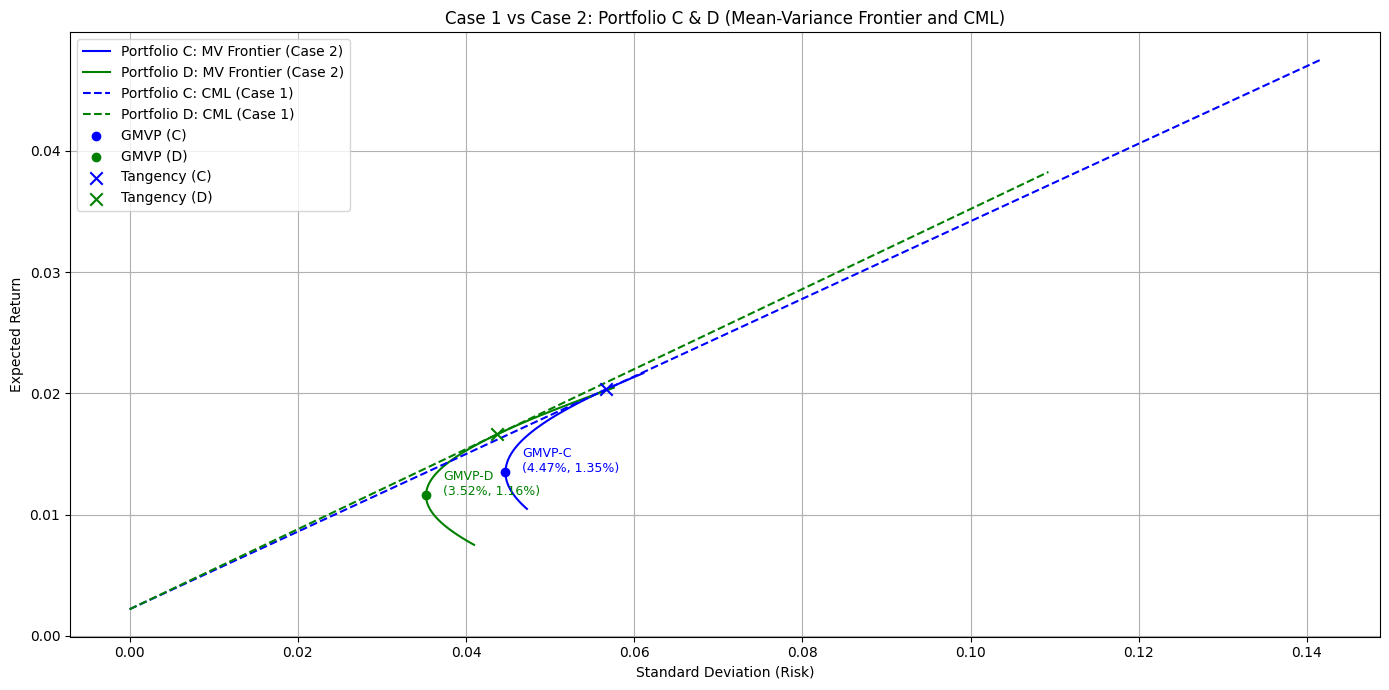

In [22]:
from scipy.optimize import minimize

# ---------------------------
# Portfolio C (Money Sector)와 D (Diverse Sector) 정의
# ---------------------------
sector_map = msf[['permno', 'flag_sector']].drop_duplicates().set_index('permno')['flag_sector']
permnos_C = sector_map[sector_map == 1].index
permnos_D = sector_map[sector_map == 0].index

ret_C = pivot_ret[permnos_C]
ret_D = pivot_ret[permnos_D]

mu_C = ret_C.mean().values
Sigma_C = ret_C.cov().values
n_C = len(mu_C)
ones_C = np.ones(n_C)

mu_D = ret_D.mean().values
Sigma_D = ret_D.cov().values
n_D = len(mu_D)
ones_D = np.ones(n_D)

rf = msp500['rf'].mean()

# ---------------------------
# MV Frontier 계산 함수 (Case 2)
# ---------------------------
def minimize_vol_case2(target_return, mu, Sigma):
    n = len(mu)
    init_w = np.ones(n) / n
    bounds = [(-1, 1)] * n
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: w @ mu - target_return}
    ]
    result = minimize(lambda w: np.sqrt(w.T @ Sigma @ w), init_w,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# ---------------------------
# Case 1: Tangency + CML 계산 함수
# ---------------------------
def get_cml(mu, Sigma, rf):
    excess_mu = mu - rf * np.ones(len(mu))
    inv_Sigma = np.linalg.inv(Sigma)
    w_tan = inv_Sigma @ excess_mu / (np.ones(len(mu)).T @ inv_Sigma @ excess_mu)
    mu_tan = mu @ w_tan
    sigma_tan = np.sqrt(w_tan.T @ Sigma @ w_tan)
    slope = (mu_tan - rf) / sigma_tan
    return w_tan, mu_tan, sigma_tan, slope

# ---------------------------
# 포트폴리오 C: Case 2 (MV Frontier) & GMVP
# ---------------------------
target_returns_C = np.linspace(mu_C.min(), mu_C.max(), 100)
frontier_vols_C = [
    np.sqrt(minimize_vol_case2(r, mu_C, Sigma_C).T @ Sigma_C @ minimize_vol_case2(r, mu_C, Sigma_C))
    for r in target_returns_C
]

inv_Sigma_C = np.linalg.inv(Sigma_C)
w_gmv_C = inv_Sigma_C @ ones_C / (ones_C.T @ inv_Sigma_C @ ones_C)
ret_gmv_C = mu_C @ w_gmv_C
vol_gmv_C = np.sqrt(w_gmv_C.T @ Sigma_C @ w_gmv_C)

# 포트폴리오 C: Case 1 (Tangency, CML)
w_tan_C, mu_tan_C, sigma_tan_C, slope_C = get_cml(mu_C, Sigma_C, rf)
sigma_vals_C = np.linspace(0, sigma_tan_C * 2.5, 100)
cml_C = rf + slope_C * sigma_vals_C

# ---------------------------
# 포트폴리오 D: Case 2 (MV Frontier) & GMVP
# ---------------------------
target_returns_D = np.linspace(mu_D.min(), mu_D.max(), 100)
frontier_vols_D = [
    np.sqrt(minimize_vol_case2(r, mu_D, Sigma_D).T @ Sigma_D @ minimize_vol_case2(r, mu_D, Sigma_D))
    for r in target_returns_D
]

inv_Sigma_D = np.linalg.inv(Sigma_D)
w_gmv_D = inv_Sigma_D @ ones_D / (ones_D.T @ inv_Sigma_D @ ones_D)
ret_gmv_D = mu_D @ w_gmv_D
vol_gmv_D = np.sqrt(w_gmv_D.T @ Sigma_D @ w_gmv_D)

# 포트폴리오 D: Case 1 (Tangency, CML)
w_tan_D, mu_tan_D, sigma_tan_D, slope_D = get_cml(mu_D, Sigma_D, rf)
sigma_vals_D = np.linspace(0, sigma_tan_D * 2.5, 100)
cml_D = rf + slope_D * sigma_vals_D

# ---------------------------
# 시각화
# ---------------------------
plt.figure(figsize=(14, 7))

# Case 2: MV Frontier
plt.plot(frontier_vols_C, target_returns_C, label='Portfolio C: MV Frontier (Case 2)', color='blue')
plt.plot(frontier_vols_D, target_returns_D, label='Portfolio D: MV Frontier (Case 2)', color='green')

# Case 1: CML
plt.plot(sigma_vals_C, cml_C, label='Portfolio C: CML (Case 1)', linestyle='--', color='blue')
plt.plot(sigma_vals_D, cml_D, label='Portfolio D: CML (Case 1)', linestyle='--', color='green')

# GMVP 표시
plt.scatter(vol_gmv_C, ret_gmv_C, color='blue', label='GMVP (C)', zorder=5)
plt.text(vol_gmv_C + 0.002, ret_gmv_C, f'GMVP-C\n({vol_gmv_C:.2%}, {ret_gmv_C:.2%})', color='blue', fontsize=9)

plt.scatter(vol_gmv_D, ret_gmv_D, color='green', label='GMVP (D)', zorder=5)
plt.text(vol_gmv_D + 0.002, ret_gmv_D, f'GMVP-D\n({vol_gmv_D:.2%}, {ret_gmv_D:.2%})', color='green', fontsize=9)

# Tangency 표시
plt.scatter(sigma_tan_C, mu_tan_C, color='blue', marker='x', s=80, label='Tangency (C)', zorder=5)
plt.scatter(sigma_tan_D, mu_tan_D, color='green', marker='x', s=80, label='Tangency (D)', zorder=5)

# 서식
plt.title("Case 1 vs Case 2: Portfolio C & D (Mean-Variance Frontier and CML)")
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Expected Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# ---------------------------
# S&P500 기준 초과수익률
# ---------------------------
excess_sp = msp500['spret'] - msp500['rf']
mean_excess_sp = excess_sp.mean()
mu_p = msp500['spret'].mean()

# ---------------------------
# Helper: 연환산 지표 계산
# ---------------------------
def annualized_stats(std_monthly, mean_excess_sp):
    return {
        "Excess Return (%)": mean_excess_sp * 12 * 100,
        "Volatility (%)": std_monthly * np.sqrt(12) * 100,
        "Sharpe Ratio": (mean_excess_sp / std_monthly) * np.sqrt(12)
    }

# ---------------------------
# Portfolio C - Case 1
# ---------------------------
ret_case1_C = ret_C @ w_tan_C
excess_case1_C = ret_case1_C - rf
x_case1_C = mean_excess_sp / excess_case1_C.mean()
adj_ret_case1_C = x_case1_C * ret_case1_C + (1 - x_case1_C) * rf
std_case1_C = adj_ret_case1_C.std()
result_case1_C = annualized_stats(std_case1_C, mean_excess_sp)

# ---------------------------
# Portfolio C - Case 2 (MV optimal portfolio with mu_p target)
# ---------------------------
A_C = ones_C.T @ inv_Sigma_C @ ones_C
B_C = ones_C.T @ inv_Sigma_C @ mu_C
C_C = mu_C.T @ inv_Sigma_C @ mu_C
Delta_C = A_C * C_C - B_C**2
gamma_C = (mu_p * A_C - B_C) / Delta_C
lambda_C = (C_C - mu_p * B_C) / Delta_C
w_mv_C = inv_Sigma_C @ (lambda_C * ones_C + gamma_C * mu_C)

ret_case2_C = ret_C @ w_mv_C
excess_case2_C = ret_case2_C - rf
x_case2_C = mean_excess_sp / excess_case2_C.mean()
adj_ret_case2_C = x_case2_C * ret_case2_C + (1 - x_case2_C) * rf
std_case2_C = adj_ret_case2_C.std()
result_case2_C = annualized_stats(std_case2_C, mean_excess_sp)

# ---------------------------
# Portfolio D - Case 1
# ---------------------------
ret_case1_D = ret_D @ w_tan_D
excess_case1_D = ret_case1_D - rf
x_case1_D = mean_excess_sp / excess_case1_D.mean()
adj_ret_case1_D = x_case1_D * ret_case1_D + (1 - x_case1_D) * rf
std_case1_D = adj_ret_case1_D.std()
result_case1_D = annualized_stats(std_case1_D, mean_excess_sp)

# ---------------------------
# Portfolio D - Case 2 (MV optimal portfolio with mu_p target)
# ---------------------------
A_D = ones_D.T @ inv_Sigma_D @ ones_D
B_D = ones_D.T @ inv_Sigma_D @ mu_D
C_D = mu_D.T @ inv_Sigma_D @ mu_D
Delta_D = A_D * C_D - B_D**2
gamma_D = (mu_p * A_D - B_D) / Delta_D
lambda_D = (C_D - mu_p * B_D) / Delta_D
w_mv_D = inv_Sigma_D @ (lambda_D * ones_D + gamma_D * mu_D)

ret_case2_D = ret_D @ w_mv_D
excess_case2_D = ret_case2_D - rf
x_case2_D = mean_excess_sp / excess_case2_D.mean()
adj_ret_case2_D = x_case2_D * ret_case2_D + (1 - x_case2_D) * rf
std_case2_D = adj_ret_case2_D.std()
result_case2_D = annualized_stats(std_case2_D, mean_excess_sp)

# ---------------------------
# S&P 500 기준
# ---------------------------
result_sp500 = annualized_stats(msp500['spret'].std(), mean_excess_sp)

# ---------------------------
# 통합 결과 정리
# ---------------------------
comparison_C_D = pd.DataFrame({
    "Portfolio C (Case 1)": pd.Series(result_case1_C),
    "Portfolio C (Case 2)": pd.Series(result_case2_C),
    "Portfolio D (Case 1)": pd.Series(result_case1_D),
    "Portfolio D (Case 2)": pd.Series(result_case2_D),
    "S&P 500": pd.Series(result_sp500)
})

comparison_C_D

,Portfolio C (Case 1),Portfolio C (Case 2),Portfolio D (Case 1),Portfolio D (Case 2),S&P 500
Excess Return (%),6.529617,6.529617,6.529617,6.529617,6.529617
Volatility (%),5.890327,18.597500,5.710355,14.073323,14.814414
Sharpe Ratio,1.108532,0.351102,1.143469,0.463971,0.440761


In [33]:
import pandas as pd

# 공통 주식 정보: permno, comnam
permnos = list(pivot_ret.columns)
names = [permno_to_name.get(p, 'Unknown') for p in permnos]

# ---------------------------
# w1b 저장 (Case 1: Matrix approach)
# ---------------------------
df_w1b = pd.DataFrame({
    'permno': permnos,
    'comnam': names,
    'weight': w_opt1.round(14)
})

# ---------------------------
# w2b 저장 (Case 2: Tangency + RF)
# ---------------------------
df_w2b = pd.DataFrame({
    'permno': permnos,
    'comnam': names,
    'weight': w_final.round(14)
})
df_w2b.loc[len(df_w2b.index)] = ['RISKFREE', 'Risk-free asset', round(rf_weight, 14)]

# ---------------------------
# w3b 저장 (Case 3: No short + RF)
# ---------------------------
df_w3b = pd.DataFrame({
    'permno': permnos,
    'comnam': names,
    'weight': w_risky.round(14)
})
df_w3b.loc[len(df_w3b.index)] = ['RISKFREE', 'Risk-free asset', round(w_rf, 14)]

# ---------------------------
# w4b 저장 (Case 4: No RF, No short)
# ---------------------------
df_w4b = pd.DataFrame({
    'permno': permnos,
    'comnam': names,
    'weight': w_case4.round(14)
})

# ---------------------------
# Excel로 저장 (4개 시트)
# ---------------------------
with pd.ExcelWriter("w_all.xlsx", engine='openpyxl') as writer:
    df_w1b.to_excel(writer, sheet_name='w1b', index=False)
    df_w2b.to_excel(writer, sheet_name='w2b', index=False)
    df_w3b.to_excel(writer, sheet_name='w3b', index=False)
    df_w4b.to_excel(writer, sheet_name='w4b', index=False)
